# required imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from gensim.models import KeyedVectors

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.utils import plot_model
from keras import layers
from keras import Input
from keras import Model

# load data

In [3]:
train_set = pd.read_csv("FactChecking/train.tsv", sep='\t')
test_set  = pd.read_csv("FactChecking/test_noy.tsv", sep='\t')

In [4]:
statements   = train_set["statement"]
labels       = train_set["label"]

# tokenize statements using keras.preprocessing.text.Tokenizer

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(statements)

#how big is vocabulary of tokenizer overlap with
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# format data for model
X = tokenizer.texts_to_sequences(statements)

test_set_X = tokenizer.texts_to_sequences(test_set["statement"])
tokenized_statement_maxlen = max(len(max(X, key=len)),
                                 len(max(test_set_X, key=len)))

X = pad_sequences(X, padding='post', maxlen=tokenized_statement_maxlen)

test_set_X = pad_sequences(test_set_X, padding='post', maxlen=tokenized_statement_maxlen)

print(np.shape(X))
print(np.shape(test_set_X))

(10268, 70)
(2565, 70)


In [6]:
def frequentVals(data, min_count=200):
        unique, counts = np.unique(data[data.notna()], return_counts=True)
        if sum(data.isna()>min_count):
            return (np.append(unique[counts>min_count],"missing"))
        return unique[counts>min_count]
        
def onehot(vals, encoded_values=None):
    if (encoded_values is None):
        encoded_values = vals.to_numpy()
    
    vals = vals.replace(np.nan, 'missing')
    onehot_encoder = OneHotEncoder(sparse=False, handle_unknown = "ignore")
    onehot_encoder.fit(encoded_values.reshape(len(encoded_values), 1))    
    ret = onehot_encoder.transform(vals.to_numpy().reshape(len(vals), 1))
    return ret

# encode additional data

determine which values are frequent enough to be one-hot encoded

In [7]:
encoded_subjects = frequentVals(train_set["subject"])
encoded_speakers = frequentVals(train_set["speaker"])
encoded_speaker_jobs = frequentVals(train_set["speaker_job"])
encoded_states = frequentVals(train_set["state"])
encoded_parties = frequentVals(train_set["party"])
encoded_contexts = frequentVals(train_set["context"])

def context_data_for_vals(dataset,
                          encoded_subjects,
                          encoded_speakers,
                          encoded_speaker_jobs,
                          encoded_states,
                          encoded_parties,
                          encoded_contexts):
    subjects = onehot(dataset["subject"],encoded_subjects)
    speakers = onehot(dataset["speaker"],encoded_speakers)
    speaker_jobs = onehot(dataset["speaker_job"],encoded_speaker_jobs)
    states = onehot(dataset["state"],encoded_states)
    parties = onehot(dataset["party"],encoded_parties)
    contexts = onehot(dataset["context"],encoded_contexts)

    context_data = np.append(subjects,speakers,1)
    context_data = np.append(context_data,speaker_jobs,1)
    context_data = np.append(context_data,states,1)
    context_data = np.append(context_data,parties,1)
    return(np.append(context_data,contexts,1))

context_data = context_data_for_vals(train_set,
                                     encoded_subjects,
                                     encoded_speakers,
                                     encoded_speaker_jobs,
                                     encoded_states,
                                     encoded_parties,
                                     encoded_contexts)

context_data_test_set = context_data_for_vals(test_set,
                                     encoded_subjects,
                                     encoded_speakers,
                                     encoded_speaker_jobs,
                                     encoded_states,
                                     encoded_parties,
                                     encoded_contexts)

context_data_size = context_data.shape[1]

# Assignig labels to data
#Section of code you want to run to perform classification for all labels


In [8]:
unique_labels = np.unique(labels)
Y = onehot(labels)
print(np.shape(Y))
label_count = np.shape(Y)[1]

(10268, 6)


Actual task is easier - we have to only find label "pants-fire" this code is for binary classufucation


In [9]:
Y = (labels == "pants-fire")
label_count=1
#guess based on apriori chance: Model should be better than this
1-(np.sum(Y)/len(Y))

0.9179976626412154

# split data into test and train set

In [10]:
id_train,id_test = train_test_split(range(len(X)),
                                    test_size = 0.25,
                                    random_state = 42)

X_train=X[id_train]
X_test =X[id_test] 

Y_train=Y[id_train]
Y_test =Y[id_test]

context_data_train = context_data[id_train]
context_data_test = context_data[id_test]                                                    

# pre-trainted embeddings
Import word2vec pre-trained word embeddings trained on google news.
It should be much better than anything we can come up with by ourself even with such rich dataset

In [11]:
embeddings_index = {}
wv_from_bin = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True) 
for word, vector in zip(wv_from_bin.vocab, wv_from_bin.vectors):
    coefs = np.asarray(vector, dtype='float32')
    embeddings_index[word] = coefs
# This variable is no longer needed.
del wv_from_bin

# helper functions
getting first val of dictionary is cumbersome. Wrap it up into convinience method

In [12]:
def first_dict_val(dic):
    values_view = dic.values()
    value_iterator = iter(values_view)
    first_value = next(value_iterator)
    return(first_value)

restrict embedding dictionary to tokens present in data and conver it to embedding matrix with rows matching token ids

In [13]:
def create_embedding_matrix(embeddings_index, word_index):
    vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
    embedding_vector_size = len(first_dict_val(embeddings_index))
    
    #preallocate matrix to save time
    embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
    
    #iterate over embedding index and save to matrix if it matches data
    for token_string, embedding_vector in embeddings_index.items():
        if token_string in word_index:
            idx = word_index[token_string] 
            embedding_matrix[idx] = np.array(
            embedding_vector, dtype=np.float32)[:embedding_vector_size]

    return embedding_matrix

# Create embedding matrix

In [14]:
embedding_matrix = create_embedding_matrix(embeddings_index, tokenizer.word_index)
# drop embedding index to save memory
del embeddings_index

# More convinience functions - plotting
Plot keras model fitting history

In [15]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


Plot preety ROC curve

In [16]:
# Plot roc
def plot_roc(y_true, y_score, class_name):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for "'+class_name+'""')
    plt.legend(loc="lower right")
    plt.show()


# Model Building helper function
build CNN statement branch using one-hot statement

In [17]:
def create_cnn_statement_branch(num_filters,
                                kernel_size,
                                conv_layer_count,
                                dense_size = 10,
                                trainable_embeddings = False):
    
    model = Sequential(name = "statement_branch")
    model.add(layers.Embedding(np.shape(embedding_matrix)[0],
                               np.shape(embedding_matrix)[1],
                               weights      = [embedding_matrix],
                               input_length = tokenized_statement_maxlen,
                               trainable    = trainable_embeddings,
                               name         = "embedding"))
    for i in range(0,conv_layer_count):
        model.add(layers.Conv1D(num_filters, kernel_size, activation='relu',name = 'conv'+str(i)))
    model.add(layers.Flatten(name="flatten"))
    model.add(layers.Dense(dense_size, activation='relu',name = "dense"))
    plot_model(model,to_file="statement_branch.png", show_shapes=True)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

Build model with only single (statement) branch.

In [18]:
def build_cnn_statement_model(num_filters,
                              kernel_size,
                              conv_layer_count,
                              output_size,
                              dense_size = 10,
                              trainable_embeddings = False):
    
    statement_input_layer = Input(shape = (tokenized_statement_maxlen,), name  = "statement")
    statement_branch = create_cnn_statement_branch(num_filters,
                                                   kernel_size,
                                                   conv_layer_count,
                                                   dense_size,
                                                   trainable_embeddings)(statement_input_layer)

    output_layer = layers.Dense(output_size,
                                activation='sigmoid',
                                name="output")(statement_branch)

    model = Model(statement_input_layer, output_layer)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


Build CNN keras model using only statement

In [19]:
def create_cnn_text_model(
                     num_filters,
                     kernel_size,
                     conv_layer_count,
                     output_size,
                     dense_size = 10,
                     trainable_embeddings = False):

    statement_input_layer = Input(shape = (tokenized_statement_maxlen,), name  = "statement")
    statement_branch = create_cnn_statement_branch(num_filters,
                                                   kernel_size,
                                                   conv_layer_count,
                                                   dense_size,
                                                   trainable_embeddings)(statement_input_layer)
    
    context_input_layer = Input(shape = (context_data_size,), name  = "context")
    context_dense_layer = layers.Dense(dense_size, activation='relu',name = "context_dense")(context_input_layer)

    concat_layer = layers.concatenate([context_dense_layer, statement_branch],name="concat")
    
    output_layer = layers.Dense(output_size,
                                activation='sigmoid',
                                name="output")(concat_layer)

    model = Model([statement_input_layer,context_input_layer], output_layer, name="cnn_model")
    plot_model(model, show_shapes=True)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# Hyperparameter optimization
wrapper for optimizer

In [20]:
model = KerasClassifier(build_fn=build_cnn_statement_model,epochs=3, batch_size=10, verbose=True)

distributions of parameters of hyperparameter optimization

In [21]:
param_grid = dict(num_filters=[16,32,64],
                  kernel_size=[2,4,8,16],
                  conv_layer_count=[2,4,8,16],
                  output_size=[label_count],
                  dense_size=[label_count*2,label_count*4,label_count*8],
                  trainable_embeddings=[True,False])


## Perform grid search
build and evaluate models and return set of parameters which were the best for this job

In [ ]:
grid = RandomizedSearchCV(estimator = model,
                          param_distributions = param_grid,
                          cv = 4, verbose = 4, n_iter = 5)#build final model
grid_result = grid.fit(X_train, Y_train,verbose=True)
#best params
best_params = grid.best_params_
print("best params:", best_params)
# Evaluate testing set
test_accuracy = grid.score(X_test, Y_test)
print("Accuracy on test set:" + str(test_accuracy))

Best parameters which search returned

In [22]:
best_params = dict(num_filters=32,
                  kernel_size=4,
                  conv_layer_count=4,
                  output_size=label_count,
                  dense_size=label_count*4,
                  trainable_embeddings=False)

Build best model to print evaluation statistics and check on labeled data 

In [24]:
model = create_cnn_text_model(*(best_params.values()))

history=model.fit({"statement": X_train, "context": context_data_train}, Y_train,
                  validation_data=({"statement": X_test, "context": context_data_test}, Y_test),epochs=3)
#plot_history(history)


Epoch 1/3
241/241 [==============================] - 2s 7ms/step - loss: 0.2979 - accuracy: 0.9113 - val_loss: 0.2816 - val_accuracy: 0.9135
Epoch 2/3
241/241 [==============================] - 2s 6ms/step - loss: 0.2627 - accuracy: 0.9195 - val_loss: 0.2902 - val_accuracy: 0.9135
Epoch 3/3
241/241 [==============================] - 2s 7ms/step - loss: 0.2505 - accuracy: 0.9195 - val_loss: 0.2848 - val_accuracy: 0.9135


Print ROC curve

In [25]:
Y_test_scores = model.predict({"statement": X_test, "context": context_data_test})

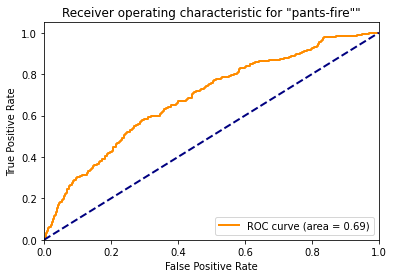

In [26]:
if (label_count>1):
    for i in range(label_count):
        plot_roc(Y_test[:,i], Y_test_scores[:,i], unique_labels[i])
else:
    plot_roc(Y_test, Y_test_scores, unique_labels[4])

# Final model
now generate model for all labeled data to maximize information model can learn

In [27]:
final_model = create_cnn_text_model(*(best_params.values()))
history=final_model.fit({"statement": X, "context": context_data}, Y,epochs=3)

Epoch 1/3
321/321 [==============================] - 2s 6ms/step - loss: 0.3048 - accuracy: 0.9069
Epoch 2/3
321/321 [==============================] - 2s 6ms/step - loss: 0.2665 - accuracy: 0.9180
Epoch 3/3
321/321 [==============================] - 2s 6ms/step - loss: 0.2496 - accuracy: 0.9180


use this final model to generate scores

In [28]:
Y_test_set_scores = final_model.predict({"statement": test_set_X, "context": context_data_test_set})
if (label_count>1):
    test_set_score = Y_test_set_scores[:,4]
else:
    test_set_score = Y_test_set_scores
np.savetxt("pants-fire-score.res",
           test_set_score,
           delimiter=",",
           fmt="%1.8f",
           header="marcin_lapinski",
           comments="")
